# Data processing
### Flood fraction
Process flood map vector files for each region. Flood maps obtained from [Copernicus EMS](https://emergency.copernicus.eu/mapping/list-of-activations-rapid). Steps to add new regions:
1. Download vector flood maps from [Copernicus EMS](https://emergency.copernicus.eu/mapping/list-of-activations-rapid)
2. Manually define subregions corresponding to those displayed on EMS using [geojson.io](geojson.io)
3. Add the geoJSON feature collection to event_geojsons.csv
4. Add the storm start and dissipation dates to event_dates.csv
5. Download IBTrACs data (note Agency period for different storms)


#### Final data formats
64x64 gridcells images representing 500 sqm each and total 32 sqkm.
#### Left to do:
- [x] Better merging of topography and bathymetry data
- [x] Better unmasking of JRC permanent water layer
- [ ] Pandas index warning
- [ ] Sort out scale stuff
- [ ] Wind field methods review dimensions
- [ ] What to do when no pressure drop in wind field?

In [1]:
from os.path import join, exists
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box, shape
from ast import literal_eval

from data_utils import *
from model_utils import *

In [2]:
# load general storm/aoi data
storm = "gombe"
region = "mossuril"
subregion = 0
gridsize = 500
stagger = 0  # staggers in (x, y) dirs, choose from {-250, 0, 250}
recalculate = True
mask = False

# define directories
wd = join("..", "data", "indata_new")
indir = join(wd, f"{storm}_{region}")
startdate, enddate = [*pd.read_csv(join(wd, "event_dates.csv"),
                                   index_col="storm").loc[storm]]

# extract storm year
dates_df = pd.read_csv(join(wd, "event_dates.csv"))
year = dates_df[dates_df['storm']==storm]['enddate'].reset_index(drop=True)
year = int(year[0][:4])

# load json for user-defined aoi
geoJSON = literal_eval(pd.read_csv(join(wd, "event_geojsons.csv"),
                                   index_col="region").loc[region][0])

poly = [shape(x['geometry']) for x in geoJSON['features']]
poly = gpd.GeoDataFrame({"geometry": poly[subregion]}, index=[0])
poly = poly.set_crs("EPSG:4326").to_crs("EPSG:3857").geometry[0]

# construct aoi polygon of standard 32x32 km size
(x, y) = (poly.centroid.x + stagger, poly.centroid.y + stagger)
dx = 16000
dy = 16000
poly = box(x-dx, y-dy, x+dx, y+dy)
aoi_pm = gpd.GeoDataFrame({"geometry": poly}, index=[0], crs="EPSG:3857")
aoi_lonlat = aoi_pm.to_crs("EPSG:4326")
print(f"Area: {aoi_pm.area[0] / (1000 * 1000)} sqkm")
grid_pm = make_grid(*aoi_pm.total_bounds, length=gridsize, wide=gridsize)
grid_lonlat = grid_pm.to_crs("EPSG:4326")
print(f"Rows and cols: {get_rows_and_cols(grid_pm, gridsize=gridsize)}")

Area: 1024.0 sqkm
Rows and cols: (64, 64)


## Flood fraction

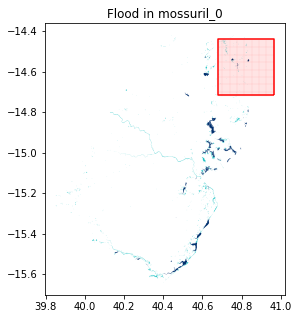

In [3]:
region_boundary = gpd.read_file(join(indir, "areaOfInterest.shp"))
flood = gpd.read_file(join(indir, "flood.shp")).to_crs('EPSG:4326')

if exists(join(indir, "hydrographyA.shp")):
    pwater = gpd.read_file(join(indir, "hydrographyA.shp"))
    trueflood = gpd.overlay(flood, pwater, how="difference")
else:
    trueflood = flood

# plot flood data
fig, ax = plt.subplots(1, figsize=(10, 5))
trueflood.plot(ax=ax, color="#21c4c5")
if exists(join(indir, "hydrographyA.shp")):
    pwater.plot(ax=ax, color="#01306e")
grid_lonlat.boundary.plot(color="red", ax=ax, linewidth=0.02)
aoi_lonlat.boundary.plot(color="red", ax=ax)
ax.set_title(f"Flood in {region}_{subregion}");

100%|████████████████████████████████████| 4096/4096 [00:00<00:00, 24311.50it/s]
/Users/alisonpeard/miniconda3/envs/hybridmodels/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


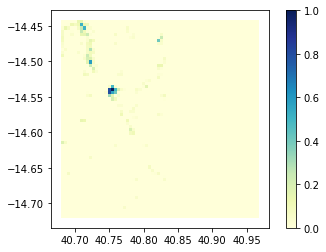

In [4]:
# load the feature_stats shapefile or else create one
if not recalculate:
    try:
        feature_gdf = gpd.read_file(join(indir, f'feature_stats_{subregion}_{stagger}.shp'))
    except:
        feature_gdf = grid_lonlat
else:
    feature_gdf = grid_lonlat

if "floodfrac" not in feature_gdf or recalculate:
    # calculate flood fraction over the grid cells in Pseudo-Mercator
    flood = gpd.clip(flood, aoi_lonlat)
    flood_pm = flood.to_crs("EPSG:3857") 
    floodfrac_gdf = get_grid_intersects(flood_pm, grid_pm)

    # save the feature_stats shapefile with flood fraction
    feature_gdf["floodfrac"] = floodfrac_gdf["floodfrac"]
    feature_gdf.to_file(join(indir, f'feature_stats_{subregion}_{stagger}.shp'))

# plot output
fig, ax = plt.subplots(1, 1)
feature_gdf.plot(column="floodfrac", cmap="YlGnBu", ax=ax, legend=True);

## GEE datasets
Load each data set, check if it's already in the feature_gdf and if not, calculate it.

In [5]:
import folium
import ee

# workaround to solve conflict with collections
import collections
collections.Callable = collections.abc.Callable

try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()


# Add EE drawing method to folium.
def add_ee_layer(self, ee_image_object, vis_params, name, show=True):
    """Method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True,
    show = show
  ).add_to(self)


folium.Map.add_ee_layer = add_ee_layer

# convert aoi to a GEE Feature Collection
aoi_ee = ee.Geometry.Polygon(aoi_lonlat.geometry[0].__geo_interface__["coordinates"],
                             proj=ee.Projection('EPSG:4326'))
location = aoi_ee.centroid().coordinates().getInfo()[::-1]

# convert grid to a GEE Feature Collection
features = []
for geom in grid_lonlat.geometry:
    poly = ee.Geometry.Polygon(geom.__geo_interface__['coordinates'],
                        proj=ee.Projection('EPSG:4326'))
    features.append(poly)

grid_ee = ee.FeatureCollection(features)
print(f"Grid size: {grid_ee.size().getInfo()}")

Grid size: 4096


### Start importing GEE datasets

Calculating bathymetry...


/Users/alisonpeard/miniconda3/envs/hybridmodels/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


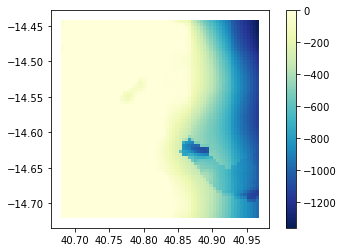

In [6]:
# GEBCO bathymetry data: 15 arcseconds (approx. 0.5km)
feature_gdf = gpd.read_file(join(indir, f'feature_stats_{subregion}_{stagger}.shp'))

if "gebco" not in feature_gdf or recalculate:
    print("Calculating bathymetry...")
    
    # get GEE image collection
    gebco = ee.Image(ee.ImageCollection("projects/sat-io/open-datasets/gebco/gebco_grid")
                      .filterBounds(aoi_ee)
                      .select("b1")
                      .median()
                      .clip(aoi_ee)
                      .unmask(999))
    
    ocean = gebco.lte(0)

    # Add reducer output to features
    mean_gebco = gebco.mask(ocean).unmask(0).reduceRegions(collection=grid_ee,
                                             reducer=ee.Reducer.mean(),
                                             scale=gridsize)  # defined by output scale, always in (m)

    gebco_list = mean_gebco.aggregate_array('mean').getInfo()
    feature_gdf["gebco"] = gebco_list
    feature_gdf.to_file(join(indir, f'feature_stats_{subregion}_{stagger}.shp'))
    
# plot output
fig, ax = plt.subplots(1, 1)
feature_gdf.plot(column='gebco', cmap="YlGnBu_r", ax=ax, legend=True);

Calculating DTM...


/Users/alisonpeard/miniconda3/envs/hybridmodels/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


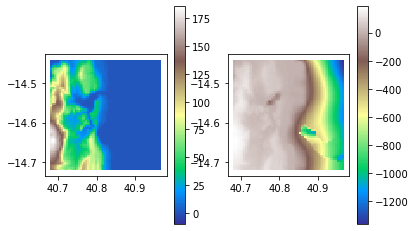

In [7]:
# FABDEM DTM (from awesome-gee-community-datasets)
recalculate=True
feature_gdf = gpd.read_file(join(indir, f'feature_stats_{subregion}_{stagger}.shp'))

if "elevation" not in feature_gdf or recalculate:
    print("Calculating DTM...")
    elev = ee.Image(ee.ImageCollection("projects/sat-io/open-datasets/FABDEM")
        .filterBounds(aoi_ee)
        .mosaic()
        .setDefaultProjection('EPSG:4326', scale=30)
        .clip(aoi_ee)
        .unmask(-999))
    
    land = elev.gte(0)
    
    # Add reducer output to the Features in the collection.
    mean_elev = elev.mask(land).unmask(0).reduceRegions(collection=grid_ee,
                                             reducer=ee.Reducer.mean(),
                                             scale=gridsize)  # defined by output scale, always in (m)
    
    elev_list = mean_elev.aggregate_array('mean').getInfo()
    feature_gdf["fabdem"] = elev_list
    feature_gdf['elevation'] = feature_gdf["gebco"] + feature_gdf["fabdem"]
    feature_gdf.to_file(join(indir, f'feature_stats_{subregion}_{stagger}.shp'))

# plot output
fig, ax = plt.subplots(1, 2)
feature_gdf.plot(column='fabdem', cmap="terrain", ax=ax[0], legend=True, vmin=-10)
feature_gdf.plot(column='elevation', cmap="terrain", ax=ax[1], legend=True);
recalculate=False

Recalculating permanent water...


/Users/alisonpeard/miniconda3/envs/hybridmodels/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


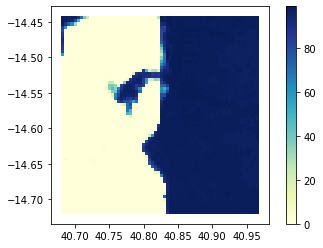

In [8]:
recalculate = True

# JRC permanent water dataset: 30 arcseconds (approx. 1km)
feature_gdf = gpd.read_file(join(indir, f'feature_stats_{subregion}_{stagger}.shp'))

if "jrc_permwa" not in feature_gdf or recalculate:
    print("Recalculating permanent water...")
    jrc_permwater = (ee.Image("JRC/GSW1_3/GlobalSurfaceWater")
                     .clip(aoi_ee)
                     .select("occurrence")
                     .unmask(0))

    # Add reducer output to the Features in the collection.
    mean_jrc_permwater = jrc_permwater.reduceRegions(collection=grid_ee,
                                             reducer=ee.Reducer.mean(),
                                             scale=gridsize)  # defined by output scale, always in (m)
    jrc_permwater_list = mean_jrc_permwater.aggregate_array('mean').getInfo()
    feature_gdf["jrc_permwa"] = jrc_permwater_list
    
    # slightly hack-y way of filling-in ocean
    max_pw = feature_gdf.jrc_permwa.describe()["max"]
    pw_ix = feature_gdf[(feature_gdf['jrc_permwa']<=90) & (feature_gdf["gebco"]<-90)].index
    feature_gdf.loc[pw_ix, "jrc_permwa"] = 100
    
    # save to gdf
    feature_gdf.to_file(join(indir, f'feature_stats_{subregion}_{stagger}.shp'))

# plot results
fig, ax = plt.subplots(1, 1)
feature_gdf.plot(column='jrc_permwa', ax=ax, cmap="YlGnBu", legend=True);

recalculate = False

Recalculating dists to water...


/Users/alisonpeard/miniconda3/envs/hybridmodels/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


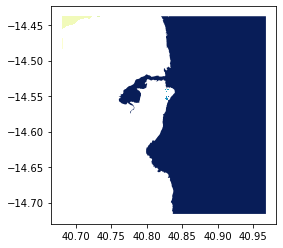

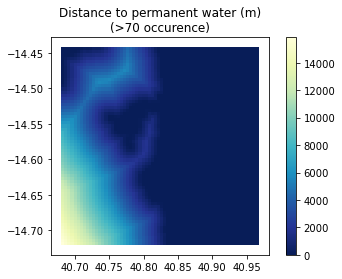

In [9]:
# Calculate distances to water
import geemap
from shapely.ops import nearest_points

def dist_to_water(gdf, water, geom_col='geometry'):
    gdf = gdf.to_crs('EPSG:3857')
    water = water.set_crs('EPSG:4326').to_crs('EPSG:3857')
    water_union = water.unary_union
    dist_list =[]
    for index, row in gdf.iterrows():
        nearest = nearest_points(row[geom_col], water_union)[1]
        dist = row[geom_col].distance(nearest)
        dist_list.append(dist)
    # Return column
    return dist_list

feature_gdf = gpd.read_file(join(indir, f'feature_stats_{subregion}_{stagger}.shp'))
if "dist_pw" not in feature_gdf or recalculate:
    print("Recalculating dists to water...")
    jrc_permwater = (ee.Image("JRC/GSW1_3/GlobalSurfaceWater")
                     .clip(aoi_ee)
                     .select("occurrence")
                     .unmask(0))
    
    water = jrc_permwater.gt(70)
    water = water.reduceToVectors(reducer=ee.Reducer.countEvery())
    
    water_gdf = geemap.ee_to_geopandas(water)
    water_gdf = water_gdf[water_gdf.label == 1]
    water_gdf.plot(cmap="YlGnBu")
    
    dist_list = dist_to_water(feature_gdf, water_gdf)
    feature_gdf['dist_pw'] = dist_list
    
    # save to gdf
    feature_gdf.to_file(join(indir, f'feature_stats_{subregion}_{stagger}.shp'))
    
# plot results
fig, ax = plt.subplots(1, 1)
feature_gdf.plot('dist_pw', cmap="YlGnBu_r", legend=True, ax=ax)
ax.set_title("Distance to permanent water (m)\n(>70 occurence)");

Calculating precipitation...


/Users/alisonpeard/miniconda3/envs/hybridmodels/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


<AxesSubplot:>

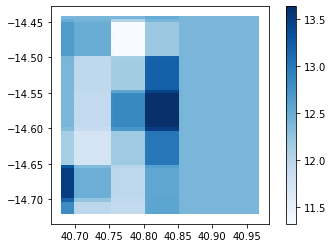

In [10]:
# CHIRPS Daily Precipitation: 0.05 degrees daily
feature_gdf = gpd.read_file(join(indir, f'feature_stats_{subregion}_{stagger}.shp'))

if "precip" not in feature_gdf or recalculate:
    print("Calculating precipitation...")
    precip = ee.Image(ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")
                      .select('precipitation')
                      .filterBounds(aoi_ee)
                      .filterDate(startdate, enddate)
                      .mean()
                      .clip(aoi_ee))
    
    # unmask using the spatial average
    spatial_mean = precip.reduceRegions(aoi_ee, ee.Reducer.mean(), scale=gridsize)  # defined by output scale, always in (m)
    spatial_mean = spatial_mean.getInfo()['features'][0]['properties']['mean']
    precip = precip.unmask(spatial_mean)

    # Add reducer output to the Features in the collection.
    mean_precip = precip.reduceRegions(collection=grid_ee,
                                             reducer=ee.Reducer.mean(),
                                             scale=gridsize)  # defined by output scale, always in (m)
    precip_list = mean_precip.aggregate_array('mean').getInfo()

    # save output
    feature_gdf["precip"] = precip_list
    feature_gdf.to_file(join(indir, f'feature_stats_{subregion}_{stagger}.shp'))

# plot results
fig, ax = plt.subplots(1, 1)
feature_gdf.plot(column='precip', ax=ax, cmap="Blues", legend=True)

Calculating soil carbon...


/Users/alisonpeard/miniconda3/envs/hybridmodels/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


<AxesSubplot:>

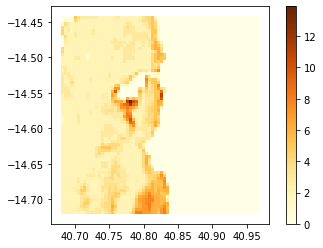

In [11]:
# soil organic carbon
feature_gdf = gpd.read_file(join(indir, f'feature_stats_{subregion}_{stagger}.shp'))

if "soilcarbon" not in feature_gdf or recalculate:
    print("Calculating soil carbon...")
    soilcarbon = (ee.Image("OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02")
                  .select('b0')
                  .clip(aoi_ee)
                  .unmask(0))

    # Add reducer output to the Features in the collection
    soilcarbon.projection().getInfo()
    scale = soilcarbon.projection().nominalScale().getInfo()
    mean_soilcarbon = soilcarbon.reduceRegions(collection=grid_ee,
                                             reducer=ee.Reducer.mean(),
                                             scale=gridsize)  # defined by output scale, always in (m)
    
    # save output file
    soilcarbon_list = mean_soilcarbon.aggregate_array('mean').getInfo()
    feature_gdf["soilcarbon"] = soilcarbon_list
    feature_gdf.to_file(join(indir, f'feature_stats_{subregion}_{stagger}.shp'))

# plot output
fig, ax = plt.subplots(1, 1)
feature_gdf.plot(column='soilcarbon', ax=ax, cmap="YlOrBr", legend=True)

Calculating mangrove cover...


/Users/alisonpeard/miniconda3/envs/hybridmodels/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


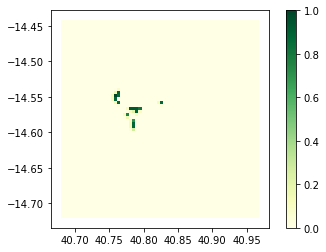

In [12]:
# mangrove forests from year 2000 Giri (2011)
feature_gdf = gpd.read_file(join(indir, f'feature_stats_{subregion}_{stagger}.shp'))

if "mangrove" not in feature_gdf or recalculate:
    print("Calculating mangrove cover...")
    mangrove = ee.Image(ee.ImageCollection("LANDSAT/MANGROVE_FORESTS")
                               .filterBounds(aoi_ee)
                               .first()
                               .clip(aoi_ee)
                               .unmask(0))

    # Add reducer output to the Features in the collection
    mean_mangrove = mangrove.reduceRegions(collection=grid_ee,
                                             reducer=ee.Reducer.mean(),
                                             scale=gridsize)  # defined by output scale, always in (m)
    mangrove_list = mean_mangrove.aggregate_array('mean').getInfo()
    feature_gdf["mangrove"] = mangrove_list
    feature_gdf.to_file(join(indir, f'feature_stats_{subregion}_{stagger}.shp'))

# plot output
fig, ax = plt.subplots(1, 1)
feature_gdf.plot(column='mangrove', ax=ax, cmap="YlGn", legend=True);

Calculating NDVI...
Masking out mangrove presence...


/Users/alisonpeard/miniconda3/envs/hybridmodels/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


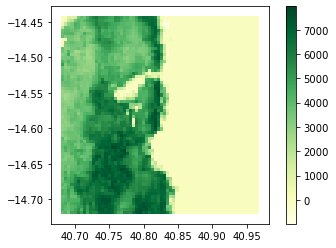

In [13]:
# NDVI (reprojected and masked from mangroves)
feature_gdf = gpd.read_file(join(indir, f'feature_stats_{subregion}_{stagger}.shp'))

if "ndvi" not in feature_gdf or recalculate:
    print("Calculating NDVI...")
    
    # reload mangroves
    mangrove = ee.Image(ee.ImageCollection("LANDSAT/MANGROVE_FORESTS")
                                   .filterBounds(aoi_ee)
                                   .first()
                                   .clip(aoi_ee))

    # NDVI
    ndvi = ee.Image(ee.ImageCollection("MODIS/006/MOD13Q1")
                    .filterBounds(aoi_ee)
                    .filterDate(ee.Date(startdate).advance(-2, 'month'), ee.Date(enddate))
                    .mean()
                    .clip(aoi_ee))

    ndvi = ndvi.select('NDVI')

    # mask out mangroves
    print("Masking out mangrove presence...")
    mangrove = mangrove.unmask(0)
    mangrove_mask = mangrove.eq(0)
    ndvi_masked = ndvi.updateMask(mangrove_mask)
    ndvi = ndvi_masked.unmask(0)

    # calculate mean over feature collection
    mean_ndvi = ndvi.reduceRegions(collection=grid_ee,
                                   reducer=ee.Reducer.mean(),
                                   scale=gridsize)  # defined by output scale, always in (m)

    ndvi_list = mean_ndvi.aggregate_array('mean').getInfo()
    feature_gdf["ndvi"] = ndvi_list


feature_gdf.to_file(join(indir, f'feature_stats_{subregion}_{stagger}.shp'))

fig, ax = plt.subplots(1, 1)
feature_gdf.plot(column='ndvi', ax=ax, cmap="YlGn", legend=True);

## IBTrACs Data
#### Steps
1. Load file
2. Choose files where WMO_WIND is not missing
3. Replace NA basin entries
4. Rescale all to MSW10
(https://library.wmo.int/doc_num.php?explnum_id=290)


Q: Kerry Emanuel correction factor for RMW? <br>
Note: check all is in km <br>
Note: grab storm speed also
- [ ] Double-check all metrics and write out clearly here.

In [14]:
# takes ages...
recalculate=True
feature_gdf = gpd.read_file(join(indir, f'feature_stats_{subregion}_{stagger}.shp'))

if not any("wnd" in col for col in feature_gdf.columns) or recalculate:
    print("Calculating wind speeds...")
    if year > 2017:
        ibtracs_gdf = gpd.read_file(join(wd, "ibtracs.csv"))[1:].replace(" ", np.nan)
        ibtracs_gdf = ibtracs_gdf[ibtracs_gdf.NAME == storm.upper()]
        units_df = pd.read_csv(join(wd, "ibtracs.csv"), dtype=str, header=0)[0:1]
    else:
        ibtracs_gdf = gpd.read_file(join(wd, "ibtracs1.csv"))[1:].replace(" ", np.nan)
        ibtracs_gdf = ibtracs_gdf[ibtracs_gdf.NAME == storm.upper()]
        units_df = pd.read_csv(join(wd, "ibtracs1.csv"), dtype=str, header=0)[0:1]

    # set geometry for gdf
    for col in ["LAT", "LON"]:
        ibtracs_gdf[col] = pd.to_numeric(ibtracs_gdf[col])
    ibtracs_gdf["geometry"] = gpd.points_from_xy(ibtracs_gdf.LON, ibtracs_gdf.LAT)
    ibtracs_gdf = ibtracs_gdf.set_crs("EPSG:4326")
    assert not ibtracs_gdf.BASIN.isna().any()

    # rescale wind speeds to MSW10
    for agency in IBTRACS_AGENCIES:
        scale, shift = IBTRACS_AGENCY_10MIN_WIND_FACTOR[agency]
        ibtracs_gdf[f'{agency}_wind'.upper()] = pd.to_numeric(ibtracs_gdf[f'{agency}_wind'.upper()])
        ibtracs_gdf[f'{agency}_wind'.upper()] += shift
        ibtracs_gdf[f'{agency}_wind'.upper()] *= scale

    # rescale WMO_WIND column to MSW10
    def rescale_wmo(wind, agency):
        wind = float(wind)
        if wind > 0:
            scale, shift = IBTRACS_AGENCY_10MIN_WIND_FACTOR[agency]
            return wind * scale + shift
        else:
            return np.nan
    ibtracs_gdf['WMO_WIND'] = ibtracs_gdf[['WMO_WIND', 'WMO_AGENCY']]\
        .apply(lambda x: rescale_wmo(x[0], x[1]), axis=1)

    # grab most-recorded wind speed if WMO not available
    if not ibtracs_gdf.WMO_WIND.isna().all():
        wind_col = "WMO_WIND"
        # agency = ibtracs_gdf["WMO_AGENCY"].mode()
        pressure_col = f"WMO_PRES"
        rmw_col = f"USA_RMW"  # double-check this, unsure
    else:
        wind_col = ibtracs_gdf[WIND_COLS].notna().sum().idxmax()
        agency = wind_col.split("_")[0]
        pressure_col = f"{agency}_PRES"
        rmw_col = f"{agency}_RMW"
    ibtracs_gdf = ibtracs_gdf.dropna(subset=wind_col).reset_index()

    # fix timestamps formatting
    newtimes = []
    for time in ibtracs_gdf["ISO_TIME"]:
        if len(time) > 8:
            date = time[:10]
            newtimes.append(time)
        else:
            newtime = f"{date} {time}"
            newtimes.append(newtime)
    
    # start calculating wind field
    centroids = feature_gdf.centroid
    wind_tracks = ibtracs_gdf.geometry
    lats = [*wind_tracks.y]
    lons = [*wind_tracks.x]

    # haversine distances
    h_distances = []
    for centroid in centroids:
        h_distances.append(haversine(centroid.x, centroid.y, lons, lats))
    h_distances = np.array(h_distances)
    assert len(ibtracs_gdf) == h_distances.shape[1]

    # calculate wind field for each time stamp
    timestamps = []
    for time in range(len(ibtracs_gdf)):
        
        # inputs for holland function
        h_dists = [x[time] for x in h_distances]
        basin = ibtracs_gdf["BASIN"][time]
        pressure_env = BASIN_ENV_PRESSURE[basin]
        pressure = float(ibtracs_gdf[pressure_col][time])
        lat = float(ibtracs_gdf["LAT"][time])
        
        # radius of maximum winds
        if units_df[rmw_col][0] == "nmile":
            r = nmile_to_km(float(ibtracs_gdf[rmw_col][time]))
        else:
            r = float(ibtracs_gdf[rmw_col][time])
            
        # maximum wind speed
        if units_df[wind_col][0] == "kts":
            wind = knots_to_mps(float(ibtracs_gdf[wind_col][time]))
        else:
            wind = ibtracs_gdf[wind_col][time]

        # calculate wind field
        wind_field = []
        for distance in h_dists:
            wind_speed = holland_wind_field(r, wind, pressure, pressure_env, distance, lat)
            wind_field.append(wind_speed)
            
        # reformat time string
        iso_time = ibtracs_gdf['ISO_TIME'][time]
        date, time = iso_time.split(" ")
        date = date[5:].replace("-", "")
        time = time[:2]
        
        # if non-neglible wind append to dataframe
        if sum(wind_field) > 0:
            feature_gdf[f"wnd{date}_{time}"] = wind_field
            timestamps.append(f"wnd{date}_{time}")
            
    feature_gdf.to_file(join(indir, f'feature_stats_{subregion}_{stagger}.shp'))
        
else:
    timemask = ["wnd" in col for col in feature_gdf.columns]
    timestamps = feature_gdf.columns[timemask]
    
recalculate = False

Calculating wind speeds...


/var/folders/pw/g3l12fr515df7s6dpdch4qx00000gn/T/ipykernel_5730/3972775398.py:65: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = feature_gdf.centroid


ZeroDivisionError: float division by zero

In [ ]:
# preview three time stamps

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, t in enumerate([26, 27, 28]):
    timestamp = timestamps[t]
    feature_gdf.plot(column=timestamp, ax=ax[i], cmap="Spectral_r", legend=True)
    ax[i].set_title(f"{timestamp}:00");

In [ ]:
# preview the average wind field
fig, ax = plt.subplots(1, 1)
feature_gdf["wind_avg"] = feature_gdf[timestamps].mean(axis=1)
feature_gdf.plot(column="wind_avg", ax=ax, cmap="Spectral_r", legend=True);
feature_gdf.to_file(join(indir, f'feature_stats_{subregion}_{stagger}.shp'))

## Final output

In [ ]:
# save all progress to dir of shapefiles
feature_gdf = gpd.read_file(join(indir, f'feature_stats_{subregion}_{stagger}.shp'))

feature_gdf["storm"] = [storm] * len(feature_gdf)
feature_gdf["region"] = [region] * len(feature_gdf)
feature_gdf["subregion"] = [subregion] * len(feature_gdf)

print("Current features:", *feature_gdf.columns)
feature_gdf.to_file(join(wd, "feature_stats", f"{storm}_{region}_{subregion}_{stagger}.shp"))

In [ ]:
# plot without masks
fig, ax = plt.subplots(2,3, figsize=(20, 5), layout="tight")

feature_gdf.plot(column="floodfrac", ax=ax[0, 0], cmap="YlGnBu", legend=True)
ax[0, 0].set_title("Flood Fraction")

feature_gdf.plot(column="jrc_permwa", ax=ax[0, 1], cmap="YlGnBu", legend=True)
ax[0, 1].set_title("Permanent Water")

feature_gdf.plot(column="ndvi", ax=ax[0, 2], cmap="YlGn", legend=True)
ax[0, 2].set_title("NDVI")

feature_gdf.plot(column="soilcarbon", ax=ax[1, 0], cmap="YlOrBr", legend=True)
ax[1, 0].set_title("Soil Carbon")

feature_gdf.plot(column="mangrove", ax=ax[1, 1], cmap="YlGn", vmin=0, legend=True)
ax[1, 1].set_title("Mangrove Presence")

feature_gdf.plot(column="wind_avg", ax=ax[1, 2], cmap="Spectral_r", legend=True)
ax[1, 2].set_title("Average Wind");

!say done